In [1]:
import IPython
import librosa.display 
import librosa 
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold, cross_val_score

sr = 44100

## データ読み込み

In [2]:
listMOBI = glob.glob('*mobi.WAV')
wav_listMOBI = sorted(listMOBI) #globはぐちゃぐちゃなので並べる
mobi_list = [i for i in range(11)]
for i in range(11):
    print("・", end="")
    mobi_list[i], sr = librosa.load(wav_listMOBI[i], sr=44100)
print("done!")

・・・・・・・・・・・done!


In [3]:
g_listA = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/a*.wav')
wav_listA = sorted(g_listA) 
g_listT = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/t*.wav')
wav_listT = sorted(g_listT) 
g_listJ = glob.glob('/Users/tomokijoya/Labolatory/卒論/卒論データ/data_Jan26/j*.wav')
wav_listJ = sorted(g_listJ) 

Alist = [i for i in range(21)]
print("Arita")
for i in range(21):
    print(".", end="")
    Alist[i], sr = librosa.load(wav_listA[i], sr=44100)
print("")

Tlist = [i for i in range(21)]
print("Tokunaga")
for i in range(21):
    print(".", end="")
    Tlist[i], sr = librosa.load(wav_listT[i], sr=44100)
print("")

Jlist = [i for i in range(21)]
print("Joya")
for i in range(21):
    print(".", end="")
    Jlist[i], sr = librosa.load(wav_listJ[i], sr=44100)
print("")
print("done!")

Arita
.....................
Tokunaga
.....................
Joya
.....................
done!


## 訓練データの整形
### 何秒ずつにするか

In [4]:
#全体の長さはバラバラで良い
def arangeList2(a_list, cut_time, one_time, sampling_rate):
    b_list = a_list[:] #スライスを使ってコピー
    if cut_time != 0:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][cut_time*sampling_rate:-cut_time*sampling_rate] #cut_time秒だけ前後を削除
    else:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sampling_rate))): #一つ当たりの数
            x = c_list[l][one_time*sampling_rate*k : one_time*sampling_rate*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [157]:
aranged = arangeList2(mobi_list, 5, 5, sr)
for i in range(11):
    print(len(aranged[i]))

11
28
231
57
106
143
127
50
73
23
53


## 行動ラベルを作成
0: 掃除機 .... 10: 声

In [158]:
label_list = []
for i in range(11):
    tmp = np.full(len(aranged[i]), i)
    label_list = np.append(label_list, tmp)
label_list.shape

(902,)

In [159]:
df_label_train = pd.DataFrame(label_list)
df_label_train.columns = ["action"]
df_label_train

,action
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
897,10.0
898,10.0
899,10.0
900,10.0


In [160]:
def makeTokucho_more(a_list):
    tokucho1 = [] 
    count=0
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            tokucho_librosa = []
            #ZCR = librosa.feature.zero_crossing_rate(y=y)
            #RMS = librosa.feature.rms(y=y)
            MFCC = librosa.feature.mfcc(y=y)
                                                                 
            #tokucho_librosa = [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            #tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
            
            tokucho_librosa.append(0) #ラベル
            
            tokucho1.append(tokucho_librosa)            
        count+=1
        print(count,end="")
    print("")
    print("終わったよ")
    
    return tokucho1

In [250]:
def makeTokucho_new(a_list):
    tmp = np.empty((1,90))
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            feature = np.empty((90))
            y = a_list[i][j]
            MFCC = librosa.feature.mfcc(y)
            RMS = librosa.feature.rms(y)
            ZCR = librosa.feature.zero_crossing_rate(y)
        
            # 特徴量を格納
            feature[0:20]  = np.mean(MFCC, axis=1)
            feature[20:40] = np.amax(MFCC, axis=1)
            feature[40:60] = np.amin(MFCC, axis=1)
            feature[60:80] = np.var(MFCC, axis=1)
    
            feature[80] = np.mean(RMS)
            feature[81] = np.amax(RMS)
            feature[82] = np.amin(RMS)
            feature[83] = np.var(RMS)
    
            feature[84] = np.mean(ZCR)
            feature[85] = np.amax(ZCR)
            feature[86] = np.amin(ZCR)
            feature[87] = np.var(ZCR)
            feature[88:] = 5
            
            tmp = np.append(tmp, feature.reshape(1,90), axis=0)
            
    
        print(i, end="")
            
    
    return tmp

In [161]:
#feature = makeTokucho_new(aranged)
feature = makeTokucho_more(aranged)

1234567891011
終わったよ


In [162]:
sound_features = [#'ZCR', 
                  #'RMS',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

header = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            header += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(1,21):
            for kind in features:
                header += f" {name}{mfcc_number}_{kind}"
            
header += ' label'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
header = header.split() #区切り文字で分割する

In [163]:
df = pd.DataFrame(feature)
df.columns = header

len_all = len(aranged[0])+len(aranged[1])
len_liv = len(aranged[9])+len(aranged[10])
len_kit = len(aranged[3])+len(aranged[4])+len(aranged[5])+len(aranged[6])+len(aranged[7])+len(aranged[8])
len_bed = len(aranged[2])

df.iloc[:len_all, -1:] = 3
df.iloc[len_all:len_all+len_bed, -1:] = 2
df.iloc[len_all+len_bed:len_all+len_bed+len_kit, -1:] = 1
df.iloc[len_all+len_bed+len_kit:len_all+len_bed+len_kit+len_liv, -1:] = 0
df

,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,MFCC2_min,MFCC2_var,MFCC3_mean,MFCC3_max,...,MFCC18_var,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,label
0,-141.283936,-107.979279,-158.576508,95.228104,63.822777,104.796844,43.184628,95.331146,-27.553074,-9.902962,...,13.017571,-7.500260,4.030851,-16.747238,14.927092,1.618969,13.832359,-8.545616,12.717286,3
1,-112.065979,-42.512768,-162.372009,945.664734,55.299030,79.031647,29.625633,89.440445,-23.692223,-8.708513,...,18.973600,-3.606941,7.263822,-19.531239,20.197824,5.232408,17.796526,-8.241194,19.728577,3
2,-150.189606,-87.553040,-172.518738,203.956787,66.011719,109.626633,47.245110,55.803989,-22.237225,-5.790296,...,10.911237,-5.854839,6.639200,-15.373717,13.718476,2.968247,11.542574,-8.388899,13.243257,3
3,-140.680313,-83.637970,-169.864182,172.673141,62.840839,106.691467,43.765247,72.574692,-19.528187,2.222392,...,11.384241,-5.553159,4.240582,-17.853024,14.263304,2.984332,13.804120,-6.862406,13.890169,3
4,-134.704254,-48.223480,-160.473480,187.564499,60.949722,114.720810,43.085220,76.193718,-19.641491,1.800314,...,14.551535,-6.478633,5.412230,-16.060778,16.750767,2.546523,14.820991,-6.711599,13.601749,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,-479.097046,-314.408051,-683.084656,4862.496582,137.099167,218.964264,-13.848916,2813.423828,-11.283734,65.374603,...,53.127861,3.270111,20.748955,-14.881287,53.240158,-2.501679,13.581947,-26.964979,52.824852,0
898,-492.253540,-353.294525,-683.086304,4068.282959,144.682419,215.101074,-6.519634,2187.184814,-4.713800,55.866402,...,66.965317,2.776015,26.648138,-14.274819,57.112347,-1.872758,15.094664,-19.123806,46.482018,0
899,-496.417358,-374.158875,-680.693542,5252.453125,148.578430,211.795197,4.501266,1466.156738,-0.283462,66.857010,...,52.170109,0.707513,17.000793,-22.763081,49.637543,-2.958890,13.667543,-21.373558,45.917061,0
900,-497.187897,-386.368774,-659.268616,4400.991211,152.611115,217.294098,58.067612,1034.571899,-2.127317,54.973137,...,60.618084,0.150395,20.409569,-23.072115,55.597900,-2.375973,12.035341,-22.845278,39.530720,0


In [164]:
df = pd.concat([df, df_label_train], axis=1)
df

,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,MFCC2_min,MFCC2_var,MFCC3_mean,MFCC3_max,...,MFCC19_mean,MFCC19_max,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,label,action
0,-141.283936,-107.979279,-158.576508,95.228104,63.822777,104.796844,43.184628,95.331146,-27.553074,-9.902962,...,-7.500260,4.030851,-16.747238,14.927092,1.618969,13.832359,-8.545616,12.717286,3,0.0
1,-112.065979,-42.512768,-162.372009,945.664734,55.299030,79.031647,29.625633,89.440445,-23.692223,-8.708513,...,-3.606941,7.263822,-19.531239,20.197824,5.232408,17.796526,-8.241194,19.728577,3,0.0
2,-150.189606,-87.553040,-172.518738,203.956787,66.011719,109.626633,47.245110,55.803989,-22.237225,-5.790296,...,-5.854839,6.639200,-15.373717,13.718476,2.968247,11.542574,-8.388899,13.243257,3,0.0
3,-140.680313,-83.637970,-169.864182,172.673141,62.840839,106.691467,43.765247,72.574692,-19.528187,2.222392,...,-5.553159,4.240582,-17.853024,14.263304,2.984332,13.804120,-6.862406,13.890169,3,0.0
4,-134.704254,-48.223480,-160.473480,187.564499,60.949722,114.720810,43.085220,76.193718,-19.641491,1.800314,...,-6.478633,5.412230,-16.060778,16.750767,2.546523,14.820991,-6.711599,13.601749,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,-479.097046,-314.408051,-683.084656,4862.496582,137.099167,218.964264,-13.848916,2813.423828,-11.283734,65.374603,...,3.270111,20.748955,-14.881287,53.240158,-2.501679,13.581947,-26.964979,52.824852,0,10.0
898,-492.253540,-353.294525,-683.086304,4068.282959,144.682419,215.101074,-6.519634,2187.184814,-4.713800,55.866402,...,2.776015,26.648138,-14.274819,57.112347,-1.872758,15.094664,-19.123806,46.482018,0,10.0
899,-496.417358,-374.158875,-680.693542,5252.453125,148.578430,211.795197,4.501266,1466.156738,-0.283462,66.857010,...,0.707513,17.000793,-22.763081,49.637543,-2.958890,13.667543,-21.373558,45.917061,0,10.0
900,-497.187897,-386.368774,-659.268616,4400.991211,152.611115,217.294098,58.067612,1034.571899,-2.127317,54.973137,...,0.150395,20.409569,-23.072115,55.597900,-2.375973,12.035341,-22.845278,39.530720,0,10.0


In [165]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))
print("ありえない",len(df[df["label"]==5]))

リビング 76
キッチン 556
寝室 231
その他 39
ありえない 0


## テストデータの整形

In [166]:
def arangeList(a_list, cut_time, total_time, one_time, sampling_rate):
    b_list = a_list[:] #スライスを使ってコピー
    if cut_time != 0:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][cut_time*sampling_rate:-cut_time*sampling_rate] #cut_time秒だけ前後を削除
    else:
        for i in range(len(a_list)):
            b_list[i] = a_list[i][:]
   
    c_list = b_list[:]
    for j in range(len(b_list)):
        c_list[j] = b_list[j][:total_time*sampling_rate] #全体をtotal_time秒にする
        
    d_list = []
    e_list = []
   
    for l in range(len(c_list)): #サンプルの数
        for k in range(int((len(c_list[l]))//(one_time*sampling_rate))): #一つ当たりの数
            x = c_list[l][one_time*sampling_rate*k : one_time*sampling_rate*(k+1)]
            d_list.append(x)
        e_list.append(d_list)
        d_list = [] #次のループに向けて初期化
    
    return e_list

In [167]:
arangedA = arangeList(Alist, 0, 120, 4, sr)
arangedT = arangeList(Tlist, 0, 120, 4, sr)
arangedJ = arangeList(Jlist, 5, 120, 4, sr)

In [168]:
def makeTokucho_more2(a_list):
    tokucho1 = [] 
    count=0
  
    for i in range(len(a_list)): #つまり21or42(iは0~20or41)
        for j in range(len(a_list[i])): #つまり29
            y = a_list[i][j]
            
            tokucho_librosa = []
            #ZCR = librosa.feature.zero_crossing_rate(y=y)
            #RMS = librosa.feature.rms(y=y)
            MFCC = librosa.feature.mfcc(y=y)
                                                                 
            #tokucho_librosa = [np.mean(ZCR),np.amax(ZCR),np.amin(ZCR),np.var(ZCR)]
            #tokucho_librosa += [np.mean(RMS),np.amax(RMS),np.amin(RMS),np.var(RMS)]
            
            for e in MFCC:
                tokucho_librosa += [np.mean(e),np.amax(e),np.amin(e), np.var(e)]
            
            tokucho_librosa.append(i % 3) #部屋
            tokucho_librosa.append(0) #正解ラベル
            tokucho_librosa.append(0) #人
            tokucho_librosa.append(i // 3) #行動
            
            
            tokucho1.append(tokucho_librosa)            
        count+=1
        print(count, end="")
    print("")
    print("終わったよ〜")
    return tokucho1

In [169]:
A_feature = makeTokucho_more2(arangedA)
T_feature = makeTokucho_more2(arangedT)
J_feature = makeTokucho_more2(arangedJ)

123456789101112131415161718192021
終わったよ〜
123456789101112131415161718192021
終わったよ〜
123456789101112131415161718192021
終わったよ〜


In [170]:
sound_features = [#'ZCR', 
                  #'RMS',
                  'MFCC']
features = ['mean', 'max', 'min', 'var']

headerS = ''
for name in sound_features:
    if name != 'MFCC':
        for kind in features:
            headerS += f" {name}_{kind}" #スペース区切りなのでスペースが大事
    else:
        for mfcc_number in range(1,21):
            for kind in features:
                headerS += f" {name}{mfcc_number}_{kind}"
            
headerS += ' room label name action'      #ヘッダーにlabel(ジャンル)をつける=======withなら必要=========
headerS = headerS.split() #区切り文字で分割する
#headerS

In [171]:
df_A = pd.DataFrame(A_feature)
df_T = pd.DataFrame(T_feature)
df_J = pd.DataFrame(J_feature)

df_A.columns = headerS
df_T.columns = headerS
df_J.columns = headerS
#正解のラベル

df_A.iloc[0:90*2,-3] = int(0)
df_A.iloc[90*2:90*5,-3] = int(1)
df_A.iloc[90*5:90*7,-3] = int(2)

df_T.iloc[0:90*2,-3] = int(0)
df_T.iloc[90*2:90*5,-3] = int(1)
df_T.iloc[90*5:90*7,-3] = int(2)

df_J.iloc[0:90*2,-3] = int(0)
df_J.iloc[90*2:90*5,-3] = int(1)
df_J.iloc[90*5:90*7,-3] = int(2)

#人の名前
df_A.iloc[:,-2] = int(7)
df_T.iloc[:,-2] = int(8)
df_J.iloc[:,-2] = int(9)

df_A = df_A[df_A["room"] == df_A["label"]]
df_T = df_T[df_T["room"] == df_T["label"]]
df_J = df_J[df_J["room"] == df_J["label"]]


df_ATJ = pd.concat([df_A, df_T, df_J])
#df_ATJ = df_ATJ.drop("room", axis=1)
df_ATJ

,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,MFCC2_min,MFCC2_var,MFCC3_mean,MFCC3_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,-516.268005,-431.581512,-564.509521,803.934631,77.325943,118.530029,43.868279,254.146271,6.238143,39.289459,...,-12.193039,20.610315,1.272897,11.672266,-11.007811,15.255553,0,0,7,0
1,-509.502716,-447.172699,-565.440796,829.906067,80.174362,119.825142,44.015934,299.547699,4.147577,44.903069,...,-10.302008,35.429195,2.736360,23.779949,-14.363731,32.207993,0,0,7,0
2,-548.164185,-494.972504,-569.811340,328.035461,61.996819,101.090462,44.875416,153.692322,21.402477,43.839207,...,-8.247828,14.526656,1.820145,10.637390,-7.375573,10.640292,0,0,7,0
3,-533.762207,-468.863800,-571.684387,858.475708,71.688049,113.600639,44.558434,397.689026,20.110060,52.021549,...,-8.453086,12.928640,2.024234,12.964762,-13.019043,16.314476,0,0,7,0
4,-538.924927,-472.570923,-570.023071,741.214600,66.231247,110.774376,45.237682,277.505829,18.129673,45.514076,...,-10.863760,15.147175,0.925959,13.414995,-10.198412,15.422253,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,-586.872803,-575.545532,-593.741699,8.290697,38.838848,46.329063,29.832973,7.901176,28.325863,37.094124,...,-4.726508,8.096113,2.717954,11.625391,-4.947915,7.887245,2,2,9,6
626,-587.430237,-579.100037,-595.560059,8.742662,38.576660,46.602196,30.724857,9.013309,27.927904,36.873680,...,-5.322609,7.900660,2.590190,10.928153,-5.773476,7.591124,2,2,9,6
627,-587.330261,-579.297852,-599.993774,9.986573,38.474098,46.160988,30.101254,7.810974,28.060909,35.113388,...,-7.054754,9.510463,2.280993,8.477888,-4.419472,6.791378,2,2,9,6
628,-587.503845,-578.945068,-596.584106,7.848323,38.521069,46.177925,25.664974,8.564336,28.483797,38.454906,...,-4.276476,7.966896,2.461682,10.151999,-4.641016,7.811487,2,2,9,6


## モデル作成と検証

In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-2], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ.iloc[:, :-4], dtype = float))
y_test = df_ATJ["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは902
trainyは902
testXは630
testyは630


In [173]:
def kondo1(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)

#最初
    ax1 = plt.subplot()
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True, cmap='Blues', fmt =".0f",ax=ax1,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)


    from sklearn.metrics import classification_report
    
    print(classification_report(y_test, y_pred, target_names=names))
    #plt.savefig('seaborn_heatmap_living_1.pdf',bbox_inches='tight')

def kondo2(X_test, y_test, model):
    names = ['living', 'kitchen', 'bedroom', 'other']
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = model.predict(X_test)


#いじる
    ax2 = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    normed_c = (cm.T *100/ cm.astype(np.float).sum(axis=1)).T
    sns.heatmap(normed_c, annot = True, cmap='Blues', fmt =".1f",ax=ax2,cbar=False,square=True,
               xticklabels=names,
               yticklabels=names)
    #plt.savefig('seaborn_heatmap_bedroom_2.pdf',bbox_inches='tight')

In [174]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.80


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

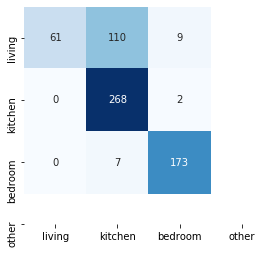

In [175]:
kondo1(X_test, y_test, model)

# 訓練データにかたよりがあるのでどうにかする

In [176]:
print("リビング",len(df[df["label"]==0]))
print("キッチン",len(df[df["label"]==1]))
print("寝室",len(df[df["label"]==2]))
print("その他",len(df[df["label"]==3]))

リビング 76
キッチン 556
寝室 231
その他 39


## ダウンサンプリング
一番ラベルの数が少ないのは0なので、0は1倍, 1はliv倍, 2はbed倍してる。(liv,bedは整数)

In [177]:
from imblearn.under_sampling import RandomUnderSampler

positive_count_train = y_train.value_counts()[0] #リビング=0の数

liv=3
bed=3
strategy = {0:positive_count_train*1, 1:positive_count_train*liv, 2:positive_count_train*bed}

rus = RandomUnderSampler(random_state=77, sampling_strategy = strategy)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
y_resampled.value_counts()

2    228
1    228
0     76
3     39
Name: label, dtype: int64

In [178]:
from sklearn.svm import SVC
model2 = SVC(kernel='rbf', random_state=None)

model2 = model.fit(X_resampled, y_resampled)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model2.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model2.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.79


              precision    recall  f1-score   support

      living       0.91      0.34      0.50       180
     kitchen       0.70      0.96      0.81       270
     bedroom       0.93      0.97      0.95       180
       other       0.00      0.00      0.00         0

    accuracy                           0.79       630
   macro avg       0.63      0.57      0.56       630
weighted avg       0.82      0.79      0.76       630



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


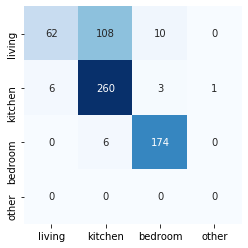

In [179]:
kondo1(X_test, y_test, model2)

## リビングの精度が悪い！
テレビは同じなのにどうして…

## テレビの音声だけでテストしてみる

In [180]:
df_ATJ

,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,MFCC2_min,MFCC2_var,MFCC3_mean,MFCC3_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,-516.268005,-431.581512,-564.509521,803.934631,77.325943,118.530029,43.868279,254.146271,6.238143,39.289459,...,-12.193039,20.610315,1.272897,11.672266,-11.007811,15.255553,0,0,7,0
1,-509.502716,-447.172699,-565.440796,829.906067,80.174362,119.825142,44.015934,299.547699,4.147577,44.903069,...,-10.302008,35.429195,2.736360,23.779949,-14.363731,32.207993,0,0,7,0
2,-548.164185,-494.972504,-569.811340,328.035461,61.996819,101.090462,44.875416,153.692322,21.402477,43.839207,...,-8.247828,14.526656,1.820145,10.637390,-7.375573,10.640292,0,0,7,0
3,-533.762207,-468.863800,-571.684387,858.475708,71.688049,113.600639,44.558434,397.689026,20.110060,52.021549,...,-8.453086,12.928640,2.024234,12.964762,-13.019043,16.314476,0,0,7,0
4,-538.924927,-472.570923,-570.023071,741.214600,66.231247,110.774376,45.237682,277.505829,18.129673,45.514076,...,-10.863760,15.147175,0.925959,13.414995,-10.198412,15.422253,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,-586.872803,-575.545532,-593.741699,8.290697,38.838848,46.329063,29.832973,7.901176,28.325863,37.094124,...,-4.726508,8.096113,2.717954,11.625391,-4.947915,7.887245,2,2,9,6
626,-587.430237,-579.100037,-595.560059,8.742662,38.576660,46.602196,30.724857,9.013309,27.927904,36.873680,...,-5.322609,7.900660,2.590190,10.928153,-5.773476,7.591124,2,2,9,6
627,-587.330261,-579.297852,-599.993774,9.986573,38.474098,46.160988,30.101254,7.810974,28.060909,35.113388,...,-7.054754,9.510463,2.280993,8.477888,-4.419472,6.791378,2,2,9,6
628,-587.503845,-578.945068,-596.584106,7.848323,38.521069,46.177925,25.664974,8.564336,28.483797,38.454906,...,-4.276476,7.966896,2.461682,10.151999,-4.641016,7.811487,2,2,9,6


In [193]:
df_ATJ_nonVoice = df_ATJ[df_ATJ["action"] != 1]
df_ATJ_nonVoice

,MFCC1_mean,MFCC1_max,MFCC1_min,MFCC1_var,MFCC2_mean,MFCC2_max,MFCC2_min,MFCC2_var,MFCC3_mean,MFCC3_max,...,MFCC19_min,MFCC19_var,MFCC20_mean,MFCC20_max,MFCC20_min,MFCC20_var,room,label,name,action
0,-516.268005,-431.581512,-564.509521,803.934631,77.325943,118.530029,43.868279,254.146271,6.238143,39.289459,...,-12.193039,20.610315,1.272897,11.672266,-11.007811,15.255553,0,0,7,0
1,-509.502716,-447.172699,-565.440796,829.906067,80.174362,119.825142,44.015934,299.547699,4.147577,44.903069,...,-10.302008,35.429195,2.736360,23.779949,-14.363731,32.207993,0,0,7,0
2,-548.164185,-494.972504,-569.811340,328.035461,61.996819,101.090462,44.875416,153.692322,21.402477,43.839207,...,-8.247828,14.526656,1.820145,10.637390,-7.375573,10.640292,0,0,7,0
3,-533.762207,-468.863800,-571.684387,858.475708,71.688049,113.600639,44.558434,397.689026,20.110060,52.021549,...,-8.453086,12.928640,2.024234,12.964762,-13.019043,16.314476,0,0,7,0
4,-538.924927,-472.570923,-570.023071,741.214600,66.231247,110.774376,45.237682,277.505829,18.129673,45.514076,...,-10.863760,15.147175,0.925959,13.414995,-10.198412,15.422253,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,-586.872803,-575.545532,-593.741699,8.290697,38.838848,46.329063,29.832973,7.901176,28.325863,37.094124,...,-4.726508,8.096113,2.717954,11.625391,-4.947915,7.887245,2,2,9,6
626,-587.430237,-579.100037,-595.560059,8.742662,38.576660,46.602196,30.724857,9.013309,27.927904,36.873680,...,-5.322609,7.900660,2.590190,10.928153,-5.773476,7.591124,2,2,9,6
627,-587.330261,-579.297852,-599.993774,9.986573,38.474098,46.160988,30.101254,7.810974,28.060909,35.113388,...,-7.054754,9.510463,2.280993,8.477888,-4.419472,6.791378,2,2,9,6
628,-587.503845,-578.945068,-596.584106,7.848323,38.521069,46.177925,25.664974,8.564336,28.483797,38.454906,...,-4.276476,7.966896,2.461682,10.151999,-4.641016,7.811487,2,2,9,6


In [194]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-2], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonVoice.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonVoice["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは902
trainyは902
testXは540
testyは540


In [195]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.80


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

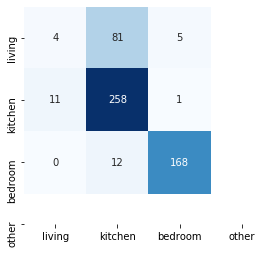

In [196]:
kondo1(X_test, y_test, model)

### テレビをテレビと認識しない…

In [189]:
df_ATJ_nonTV = df_ATJ[df_ATJ["action"] != 0]
#df_ATJ_nonTV

In [190]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(df.iloc[:, :-2], dtype = float))
y_train = df["label"]
X_test = scaler.fit_transform(np.array(df_ATJ_nonTV.iloc[:, :-4], dtype = float))
y_test = df_ATJ_nonTV["label"]
    
print('trainXは'+str(len(X_train)))
print('trainyは'+str(len(y_train)))
print('testXは'+str(len(X_test)))
print('testyは'+str(len(y_test)))

trainXは902
trainyは902
testXは540
testyは540


In [191]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', random_state=None)

model = model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# トレーニングデータに対する精度
pred_train = model.predict(X_train)

accuracy_train = accuracy_score(y_train, pred_train)

print('トレーニングデータに対する正解率： %.2f' % accuracy_train)
    
# テストデータに対する精度
pred_test = model.predict(X_test)

accuracy_test = accuracy_score(y_test, pred_test)


print('テストデータに対する正解率： %.2f' % accuracy_test)

トレーニングデータに対する正解率： 1.00
テストデータに対する正解率： 0.92


              precision    recall  f1-score   support

      living       1.00      0.67      0.80        90
     kitchen       0.88      0.99      0.93       270
     bedroom       0.99      0.96      0.97       180
       other       0.00      0.00      0.00         0

    accuracy                           0.92       540
   macro avg       0.72      0.65      0.68       540
weighted avg       0.94      0.92      0.92       540



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


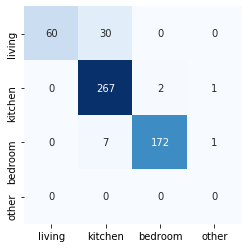

In [192]:
kondo1(X_test, y_test, model)